In [1]:
import sys
import logging

so = open("data.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)


In [1]:
#import packages
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np
import multiprocessing as mp
import time

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs
import dask

In [3]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
# open the catalog using the intake function
col = intake.open_esm_datastore(cat_url)
#view the catalog
col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


In [4]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["TEMP"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)


# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocnO2 = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["O2"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)


# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocnsalt = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["SALT"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)


# Get more detailed: search for monthly output for the 20th century and RCP8.5 
col_ocnsst = col.search(
    frequency=["monthly"],
    component="ocn",
    variable=["SST"],
    experiment=["HIST", "20C", "RCP85"],  # ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members) 
)


In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets_temp = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, 
    storage_options={"anon": True})

print(f"\nDataset dictionary keys:\n {dsets_temp.keys()}") #print to make sure we are getting the correct set of keys


# Load catalog entries for subset into a dictionary of xarray datasets
dsets_o2 = col_ocnO2.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, 
    storage_options={"anon": True})

print(f"\nDataset dictionary keys:\n {dsets_o2.keys()}") #print to make sure we are getting the correct set of keys


# Load catalog entries for subset into a dictionary of xarray datasets
dsets_salt = col_ocnsalt.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, 
    storage_options={"anon": True})

print(f"\nDataset dictionary keys:\n {dsets_salt.keys()}") #print to make sure we are getting the correct set of keys


# Load catalog entries for subset into a dictionary of xarray datasets
dsets_sst = col_ocnsst.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, 
    storage_options={"anon": True})

print(f"\nDataset dictionary keys:\n {dsets_salt.keys()}") #print to make sure we are getting the correct set of keys


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.20C.monthly', 'ocn.RCP85.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.20C.monthly', 'ocn.RCP85.monthly'])


In [6]:
# Define Xarray datasets corresponding to the two experiments
ds_20C_t = dsets_temp["ocn.20C.monthly"]
ds_RCP85_t = dsets_temp["ocn.RCP85.monthly"]



ds_20C_o = dsets_o2["ocn.20C.monthly"]
ds_RCP85_o = dsets_o2["ocn.RCP85.monthly"]



ds_20C_s = dsets_salt["ocn.20C.monthly"]
ds_RCP85_s = dsets_salt["ocn.RCP85.monthly"]



ds_20C_sst = dsets_salt["ocn.20C.monthly"]
ds_RCP85_sst = dsets_salt["ocn.RCP85.monthly"]


In [7]:
merge_ds_o = xr.concat([ds_20C_o, ds_RCP85_o], dim ='time')
merge_ds_t = xr.concat([ds_20C_t, ds_RCP85_t], dim ='time')
merge_ds_s = xr.concat([ds_20C_s, ds_RCP85_s], dim ='time')
merge_ds_sst = xr.concat([ds_20C_sst, ds_RCP85_sst], dim ='time')

In [8]:
#select just one point on the graph (this point is closest to channel islands)
test_2 = merge_ds_t.TEMP.isel(nlat=(280), nlon=(240))

test_2

<xarray.DataArray 'TEMP' (member_id: 40, time: 2172, z_t: 60)>
dask.array<getitem, shape=(40, 2172, 60), dtype=float32, chunksize=(1, 6, 60), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

In [9]:
%%time

#create to nc file here:
# save file - don't forget the .nc extension!
test_2.to_netcdf('20C_rcp85_temp.nc')



KeyboardInterrupt: 

In [13]:
# open to check:
check = xr.open_dataset('20C_rcp85_temp.nc'
)
check

<xarray.Dataset> Size: 21MB
Dimensions:    (member_id: 40, time: 2172, z_t: 60)
Coordinates:
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 17kB 1920-01-16 12:00:00 ... 2100-12-16 12:00:00
  * z_t        (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    TEMP       (member_id, time, z_t) float32 21MB ...

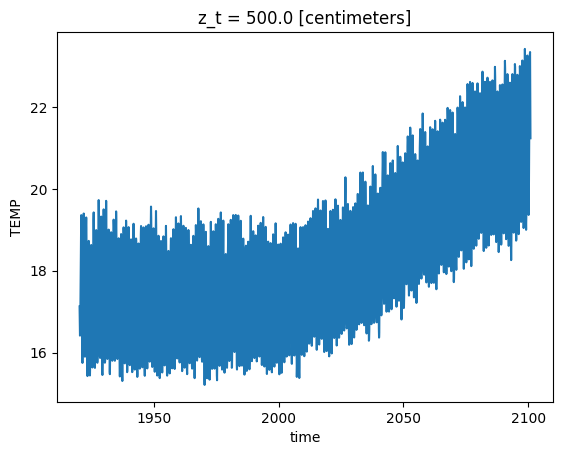

In [17]:
check_2 = check.mean("member_id")

#select a member_id
check_2.TEMP.sel(z_t = 0, method = "nearest").plot()

